2023-08-20 09:06:08.090389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 09:06:09.120854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


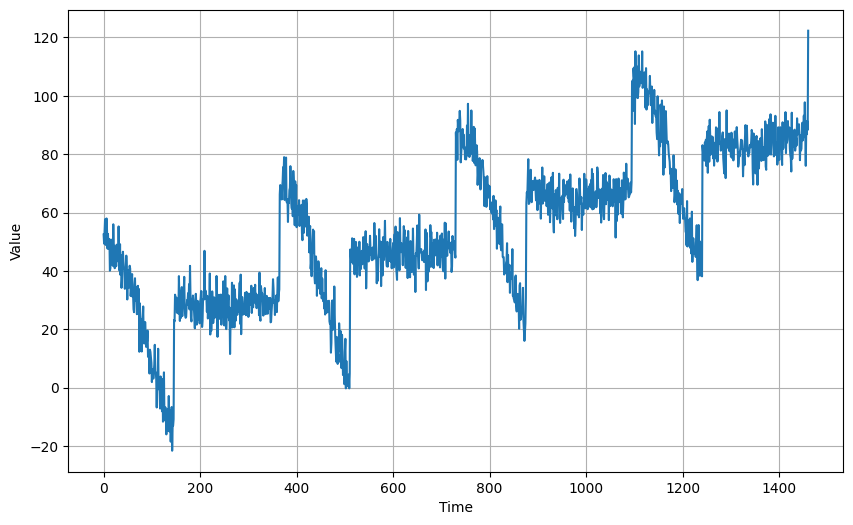

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series_noise = series + noise

plt.figure(figsize=(10, 6))
plot_series(time, series_noise)
plt.show()

split_time = 1000
time_train = time[:split_time]
x_train = series_noise[:split_time]
time_valid = time[split_time:]
x_valid = series_noise[split_time:]

In [2]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [3]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

2023-08-20 09:10:18.986093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-20 09:10:18.987486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-20 09:10:18.988498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-08-20 09:10:19.208202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:10:19.208444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:10:19.399553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

33/33 [==============================] - 3s 6ms/step - loss: 64.2256 - mae: 64.7253 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 58.4127 - mae: 58.9122 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 51.4792 - mae: 51.9792 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 5ms/step - loss: 43.7097 - mae: 44.2097 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 5ms/step - loss: 35.0202 - mae: 35.5202 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 25.3124 - mae: 25.8115 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 5ms/step - loss: 15.7264 - mae: 16.2216 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 5ms/step - loss: 11.0831 - mae: 11.5721 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 5ms/step - loss: 10.5049 - mae: 10.9926 - lr: 2.5119

(1e-08, 0.0001, 0.0, 30.0)

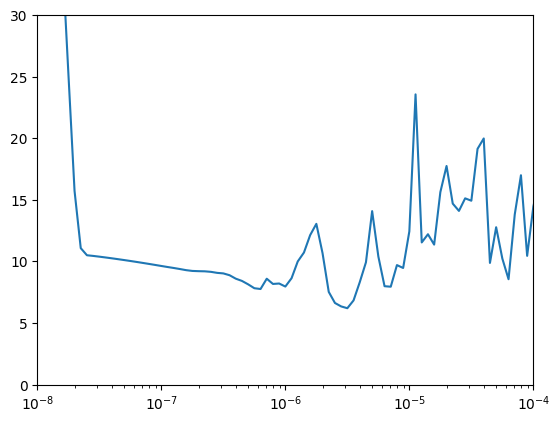

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

2023-08-20 09:11:09.674128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-20 09:11:09.675445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-20 09:11:09.676506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/500


2023-08-20 09:11:09.901669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:11:09.901982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:11:10.079159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

     33/Unknown - 2s 5ms/step - loss: 68.1496 - mae: 68.6496

2023-08-20 09:11:12.207840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:11:12.208092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:11:12.381185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

33/33 [==============================] - 3s 26ms/step - loss: 68.1496 - mae: 68.6496 - val_loss: 65.3197 - val_mae: 65.8197
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 13.5669 - mae: 14.0583 - val_loss: 23.6679 - val_mae: 24.1663
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 15.7887 - mae: 16.2813 - val_loss: 28.0122 - val_mae: 28.5110
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 10.9894 - mae: 11.4817 - val_loss: 19.9881 - val_mae: 20.4868
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 10.0638 - mae: 10.5545 - val_loss: 17.1815 - val_mae: 17.6776
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 8.1891 - mae: 8.6769 - val_loss: 13.4404 - val_mae: 13.9328
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 7.5033 - mae: 7.9932 - val_loss: 12.1389 - val_mae: 12.6285
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - los

In [12]:
model = keras.models.load_model("my_checkpoint.h5")

rnn_forecast = model.predict(series_noise[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

2023-08-20 09:11:36.401703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-20 09:11:36.402892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-20 09:11:36.403847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 557ms/step


6.3051605

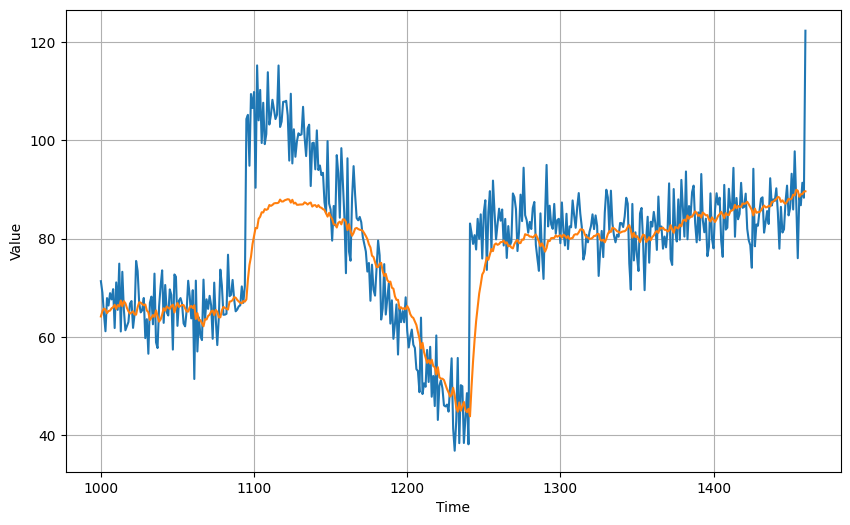

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [18]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

2023-08-20 09:29:00.517988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-20 09:29:00.519290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-20 09:29:00.520280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-08-20 09:29:00.734638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:29:00.734957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:29:00.915839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

8/8 [==============================] - 2s 9ms/step - loss: 23.4423 - mae: 23.9374 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 23.4114 - mae: 23.9065 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 23.3625 - mae: 23.8575 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 23.3032 - mae: 23.7982 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 23.2338 - mae: 23.7292 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 23.1584 - mae: 23.6542 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 23.0744 - mae: 23.5703 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 22.9857 - mae: 23.4817 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 22.8860 - mae: 23.3817 - lr: 2.5119e-08
Epoch 10/100


(1e-08, 0.0001, 0.0, 30.0)

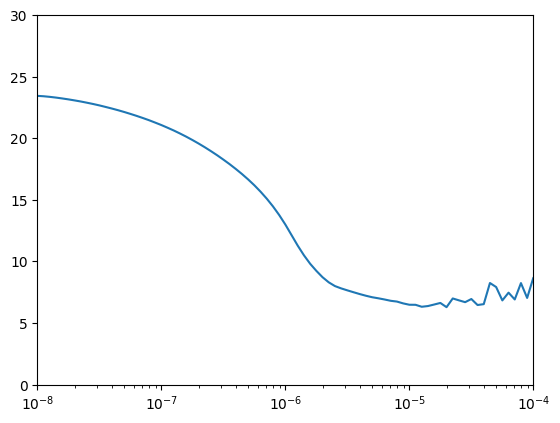

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

2023-08-20 09:30:21.555066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-20 09:30:21.556421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-20 09:30:21.557483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/500


2023-08-20 09:30:21.773820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:30:21.774224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:30:21.963109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

      1/Unknown - 2s 2s/step - loss: 24.1341 - mae: 24.6304

2023-08-20 09:30:24.234597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:30:24.235012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:30:24.424690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

8/8 [==============================] - 3s 106ms/step - loss: 19.0052 - mae: 19.4996 - val_loss: 19.9009 - val_mae: 20.3949
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 12.6264 - mae: 13.1166 - val_loss: 20.3455 - val_mae: 20.8397
Epoch 3/500
8/8 [==============================] - 0s 17ms/step - loss: 9.9771 - mae: 10.4628 - val_loss: 18.5823 - val_mae: 19.0765
Epoch 4/500
8/8 [==============================] - 0s 22ms/step - loss: 8.8782 - mae: 9.3625 - val_loss: 13.3535 - val_mae: 13.8422
Epoch 5/500
8/8 [==============================] - 0s 15ms/step - loss: 8.2948 - mae: 8.7799 - val_loss: 14.3173 - val_mae: 14.8080
Epoch 6/500
8/8 [==============================] - 0s 17ms/step - loss: 7.8393 - mae: 8.3234 - val_loss: 11.8553 - val_mae: 12.3407
Epoch 7/500
8/8 [==============================] - 0s 14ms/step - loss: 7.3869 - mae: 7.8697 - val_loss: 12.0304 - val_mae: 12.5194
Epoch 8/500
8/8 [==============================] - 0s 17ms/step - loss: 7.1202 - m

In [26]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [27]:
model = keras.models.load_model("my_checkpoint.h5")
rnn_forecast = model_forecast(model, series_noise[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

2023-08-20 09:33:01.210053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-20 09:33:01.211490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-20 09:33:01.212511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

45/45 [==============================] - 1s 5ms/step


4.9228654

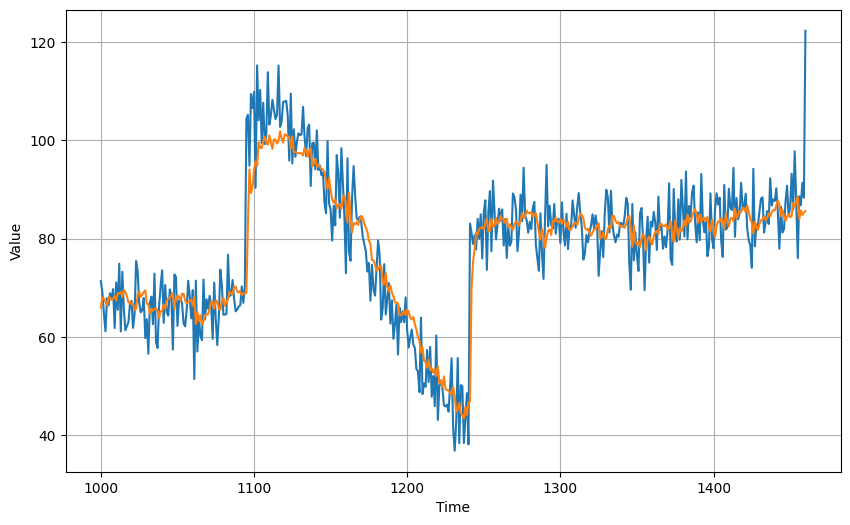

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

Epoch 1/100


2023-08-20 09:34:19.268765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:34:19.269111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:34:21.265678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


8/8 [==============================] - 5s 144ms/step - loss: 41.6209 - mae: 42.1201 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 41.2796 - mae: 41.7788 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 40.9160 - mae: 41.4151 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 40.4882 - mae: 40.9872 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 39.9339 - mae: 40.4326 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 39.1537 - mae: 39.6521 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 37.9208 - mae: 38.4194 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 35.9517 - mae: 36.4504 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 32.8918 - mae: 33.3902 - lr: 1.8478e-04
Epo

(0.0001, 0.1, 0.0, 30.0)

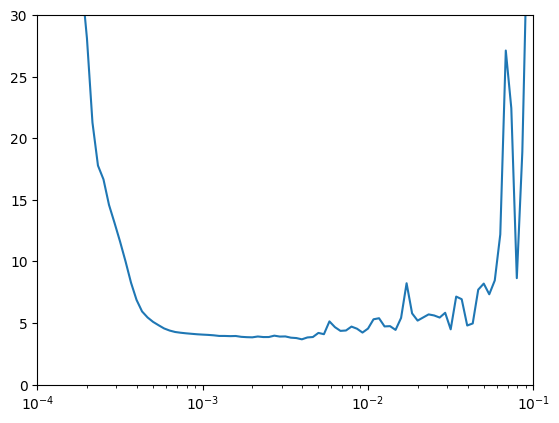

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(0.0001, 0.1, 0.0, 30.0)

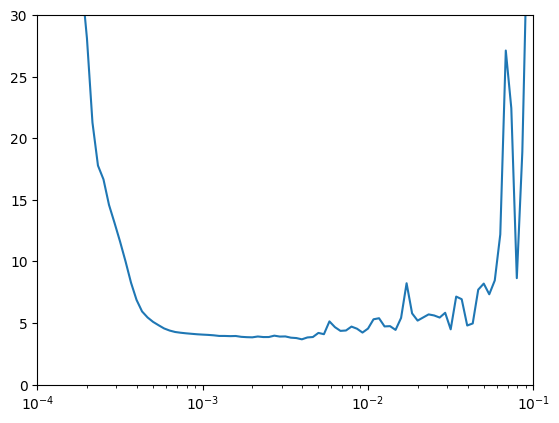

In [30]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


2023-08-20 09:36:18.616013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:36:18.616353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]


      6/Unknown - 3s 11ms/step - loss: 42.1444 - mae: 42.6432

2023-08-20 09:36:21.251982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:36:21.252356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461,1]
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 3s 124ms/step - loss: 42.4522 - mae: 42.9511 - val_loss: 77.4555 - val_mae: 77.9555
Epoch 2/500
8/8 [==============================] - 0s 22ms/step - loss: 40.8461 - mae: 41.3453 - val_loss: 73.1766 - val_mae: 73.6766
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 36.4829 - mae: 36.9813 - val_loss: 55.4451 - val_mae: 55.9451
Epoch 4/500
8/8 [==============================] - 0s 23ms/step - loss: 22.5095 - mae: 23.0051 - val_loss: 31.2069 - val_mae: 31.7042
Epoch 5/500
8/8 [==============================] - 0s 23ms/step - loss: 18.0242 - mae: 18.5184 - val_loss: 22.1215 - val_mae: 22.6173
Epoch 6/500
8/8 [==============================] - 0s 22ms/step - loss: 13.0255 - mae: 13.5156 - val_loss: 15.2535 - val_mae: 15.7417
Epoch 7/500
8/8 [==============================] - 0s 22ms/step - loss: 9.0852 - mae: 9.5719 - val_loss: 11.9422 - val_mae: 12.4303
Epoch 8/500
8/8 [==============================] - 0s 23ms/step - loss: 7.0

In [34]:
model = keras.models.load_model("my_checkpoint.h5")
cnn_forecast = model_forecast(model, series_noise[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

2023-08-20 09:37:15.484129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1461,1]
	 [[{{node Placeholder/_0}}]]
2023-08-20 09:37:15.484444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1461,1]
	 [[{{node Placeholder/_0}}]]


44/44 [==============================] - 0s 3ms/step


4.595063

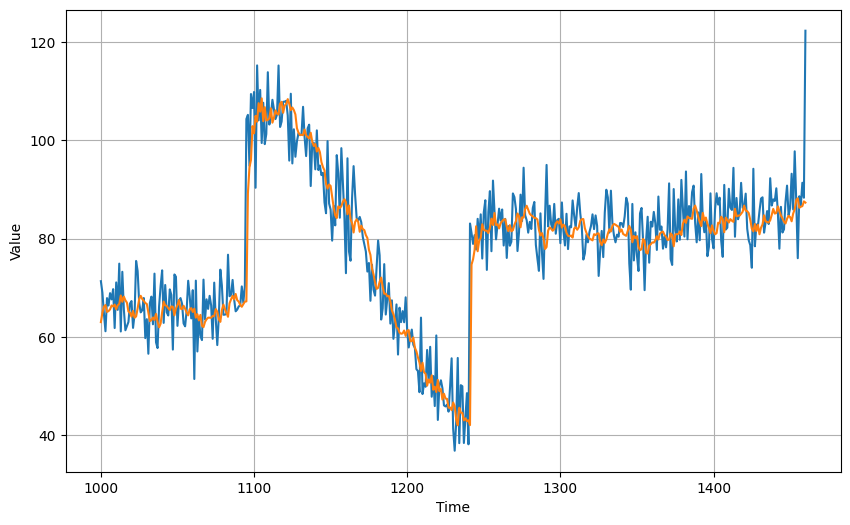

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           3